# Diagnosis of Covid19, Pneumonia and Tuberculosis

This notebook was created by Dror Chen and Hadas Dayan as part of the Data Sciense workshop at the Open University of Israel, Fall 2022.

# Introduction

## What is Pneumonia?
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

For more detailed information:

https://en.wikipedia.org/wiki/Pneumonia


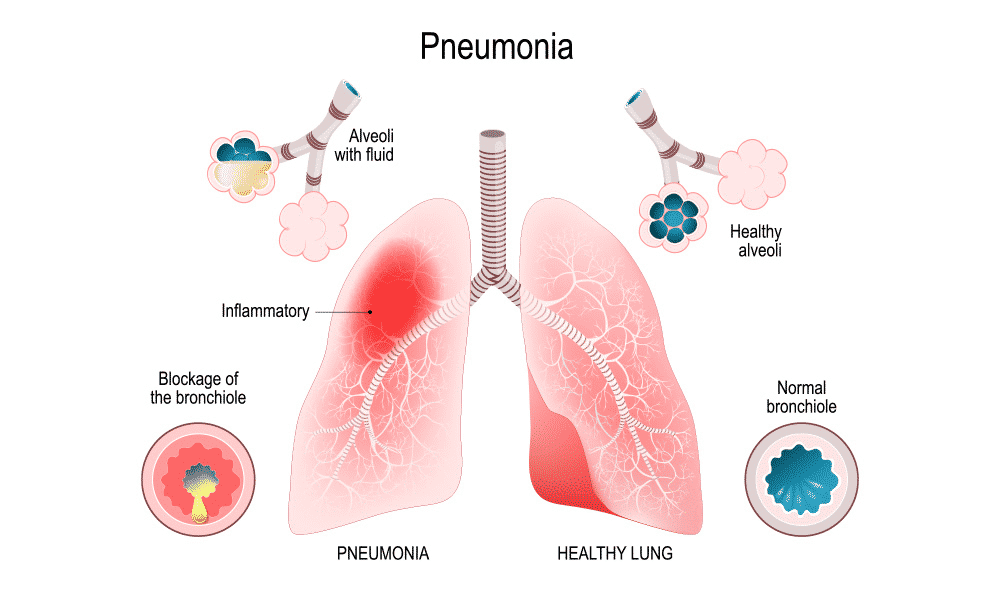

## What is Tuberculosis?
Tuberculosis is an infectious disease usually caused by Mycobacterium tuberculosis bacteria. Tuberculosis generally affects the lungs, but it can also affect other parts of the body. Most infections show no symptoms, in which case it is known as latent tuberculosis. Around 10% of latent infections progress to active disease which, if left untreated, kill about half of those affected. Typical symptoms of active TB are chronic cough with blood-containing mucus, fever, night sweats, and weight loss. Infection of

Tuberculosis is spread from one person to the next through the air when people who have active TB in their lungs cough, spit, speak, or sneeze. People with Latent TB do not spread the disease. Active infection occurs more often in people with HIV/AIDS and in those who smoke. Diagnosis of active TB is based on chest X-rays, as well as microscopic examination and culture of body fluids. Diagnosis of Latent TB relies on the tuberculin skin test or blood tests.

For more detailed information:

https://en.wikipedia.org/wiki/Tuberculosis

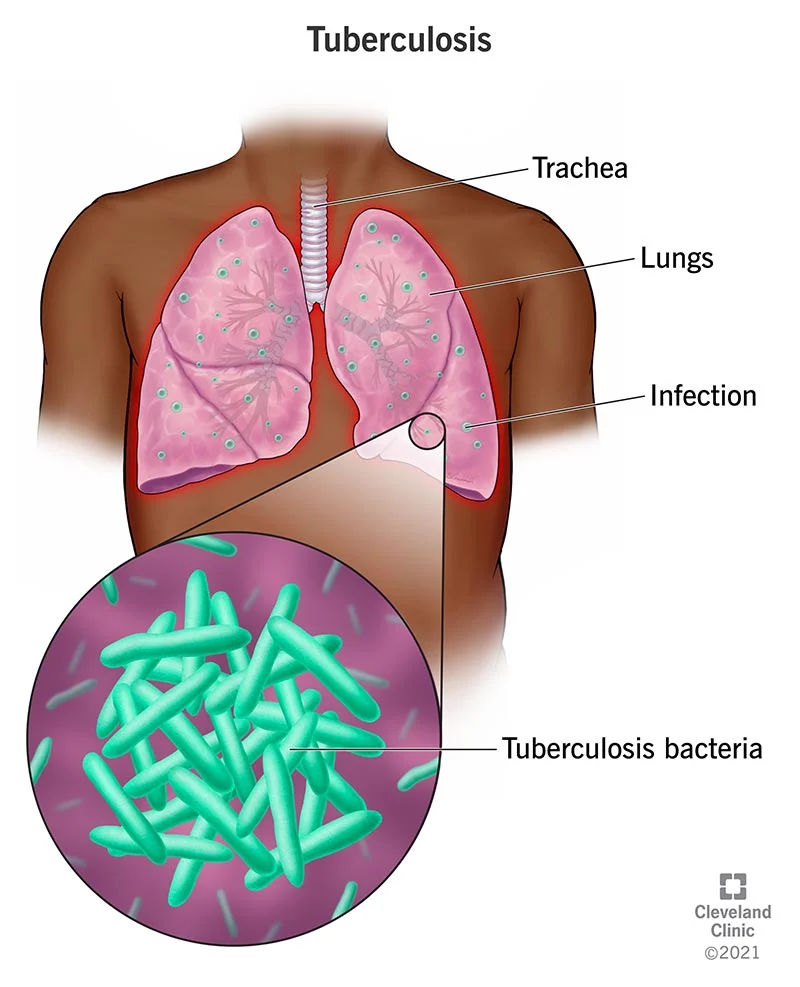

## What is Covid 19?
Coronavirus disease 2019 (COVID-19) is a contagious disease caused by a virus, the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2).

The symptoms of COVID‑19 are variable but often include fever, cough, headache, fatigue, breathing difficulties, loss of smell, and loss of taste. Symptoms may begin one to fourteen days after exposure to the virus. At least a third of people who are infected do not develop noticeable symptoms. Of those who develop symptoms noticeable enough to be classified as patients, most (81%) develop mild to moderate symptoms (up to mild pneumonia), while 14% develop severe symptoms (dyspnea, hypoxia, or more than 50% lung involvement on imaging), and 5% develop critical symptoms (respiratory failure, shock, or multiorgan dysfunction).

For more detailed information:

https://en.wikipedia.org/wiki/COVID-19

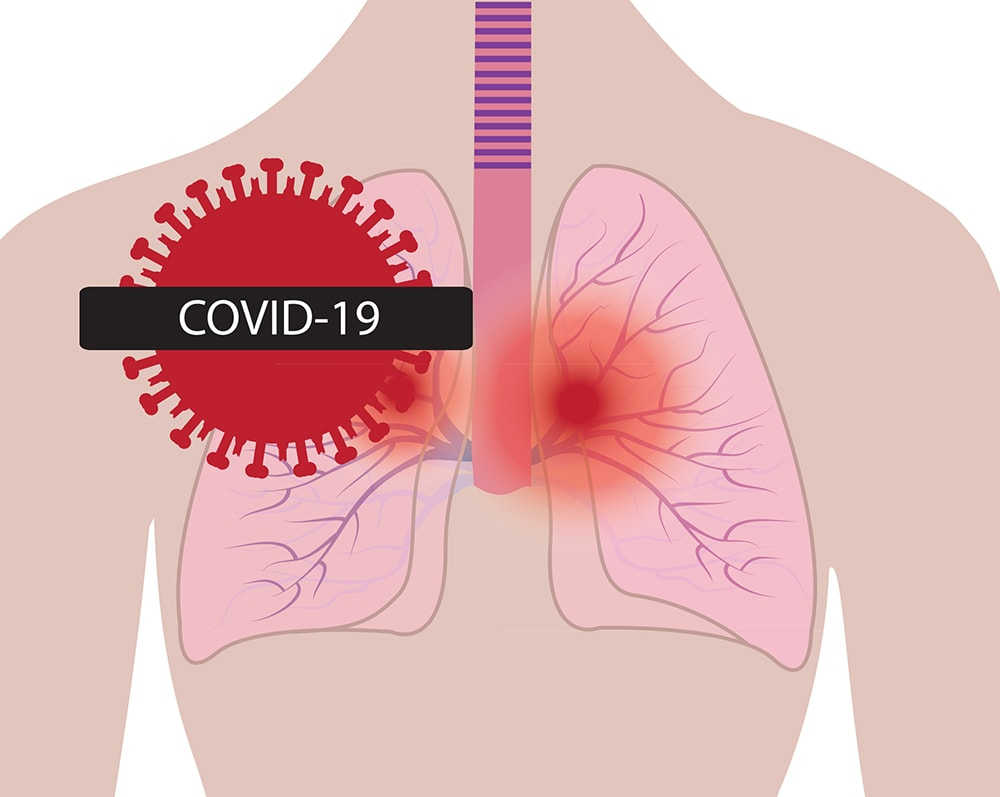


## Our data
### Building and processing the dataset

All images are preprocessed and resized to 224x224 in PNG format.
We are creating a dataset using other open source datasets by merging them. The dataset is highly imbalanced and it might contain duplicate images. The motivation for creating this dataset was to build a model that could correctly classify Tuberculosis, Pneumonia, Covid and Normal/Healthy Chest X-ray images.

### Content
A total of 20349 x-ray images are present, divided to 4 classes, COVID19, Normal, Pneuomonia and Tuberculosis.

12573 Normal images

10218 Pneuomonia images

1788 Tuberculosis images

1626 COVID19 images


##### Datasets that were used to create this imbalanced dataset:
1. https://www.kaggle.com/datasets/roshanmaur/imbalanced-tuberculosis-and-pnuemonia-dataset - A dataset containing 3 different classes of X-Ray images, healthy (normal), Pneumonia, and Tuberculosis images.
2. https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images - A dataset containing 3 different classes of X-Ray images, healthy (normal), Pneumonia, and Covid19 images.
3. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia - A dataset containing 2 different classes of X-Ray images, healthy (normal) and Pneumonia.


### Inspiration

Help the researcher and medical community to detect and classify COVID19, Tuberculosis and Pneumonia from Chest X-Ray Images using Deep Learning.


## Goal


Our purpose is to be able to identify diseases originating from the lungs via chest X-ray images. Both of us were highly interested in medical problems and image classification & analysis. We found a lot of datasets on kaggle for chest X-ray, however we wanted to mess with a large dataset with several types of classifications, so we decided to combine some chest x-ray datasets to increase our interest and take it for today's times to identify covid19 by chest x-rays.
We believe that the ability to detect lung diseases through an algorithm may shorten detection and diagnosis times, reduce human errors and consequently save patients' lives and reduce additional complications.

Today, machine learning has a phenomenal range of applications, including in health and diagnostics. Our project will explain the complete pipeline from data processing to predicting results, and it will explain how to build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of Pneumonia, Tuberculosis and Covid19. This is especially useful during these current times as Covid19 is known to cause Pneumonia.

We believe solving these groups of problems is highly important. Being able to detect diseases using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.
To reach our goal we will create a machine learning model with several architectures: RandomForest classifier, our own CNN, ResNet50V2 and ResNet34. We will examine the success of each of the models to determine the presence or absence of Pneumonia, Tuberculosis and Covid19 in a person from an X-ray image.

## EDA

In [1]:
import os
import pandas as pd
from datasets import load_dataset, load_from_disk, load_metric
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from transformers import pipeline, AutoFeatureExtractor
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
from tensorflow.keras.preprocessing import image as tsimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import hashlib
from keras.layers import Flatten
from skimage.io import imread
import cv2
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
import filecmp
import itertools
from sklearn.utils import class_weight
from IPython.display import display
from IPython.display import Image as IPYImage
from transformers import pipeline
from lime import lime_image
from skimage.segmentation import mark_boundaries

We ran this notebook many times, so in order to reduce waiting time on each iteration, we are saving valuable training data history and the models themselves to the disk.

In [2]:
name = "4_classes"
working_dir = os.getcwd()

rfm_load_model = True
rfm_save_model = False
rfm_saved_model_path = os.path.join(working_dir, f'RFM_{name}.h5')

overfitted_cnn_load_model = True
overfitted_cnn_save_model = False
overfitted_cnn_train_again = False
overfitted_cnn_saved_model_path = os.path.join(working_dir, f'CNN_overfitted_{name}')
overfitted_cnn_saved_model_fit_results_path = os.path.join(working_dir, f'CNN_overfitted_{name}_History.bin')

overfitted_cnn_load_5epochs_model = True
overfitted_cnn_save_5epochs_model = False
overfitted_cnn_train_5epochs_again = False
overfitted_cnn_saved_5epochs_model_path = os.path.join(working_dir, f'CNN_overfitted_5epochs_{name}')
overfitted_cnn_saved_5epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_overfitted_5epochs_{name}_History.bin')

cnn_load_model = True
cnn_save_model = False
cnn_train_again = False
cnn_saved_model_path = os.path.join(working_dir, f'CNN_{name}')
cnn_saved_model_fit_results_path = os.path.join(working_dir, f'CNN_{name}_History.bin')

cnn_load_5epochs_model = True
cnn_save_5epochs_model = False
cnn_train_5epochs_again = False
cnn_saved_5epochs_model_path = os.path.join(working_dir, f'CNN_5epochs_{name}')
cnn_saved_5epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_5epochs_{name}_History.bin')

cnn_load_10epochs_model = True
cnn_save_10epochs_model = False
cnn_train_10epochs_again = False
cnn_saved_10epochs_model_path = os.path.join(working_dir, f'CNN_10epochs_{name}')
cnn_saved_10epochs_model_fit_results_path = os.path.join(working_dir, f'CNN_10epochs_{name}_History.bin')

resnet_load_model = True
resnet_save_model = False
resnet_train_again = False
pretrained_resnet50v2_saved_model_path = os.path.join(working_dir, f'ResNet50V2_{name}')
pretrained_resnet50v2_saved_model_fit_results_path = os.path.join(working_dir, f'ResNet50V2_{name}_History.bin')

fastai_models_path = os.path.expanduser('~\\Documents\\FastAI')
fastai_resnet34_load_model = True
fastai_resnet34_log_append = True
fastai_resnet34_save_model = False
fastai_resnet34_calculate_lr = False
fastai_resnet34_calculate_plot_top_losses = False
fastai_resnet34_calculate_confusion_matrix = False
fastai_resnet34_model_name = "ResNet34"
fastai_resnet34_saved_model_log_path = os.path.join(working_dir, f'ResNet34_History_{name}.csv')
fastai_resnet34_saved_lr_find_plot = os.path.join(working_dir, f'ResNet34_lr_find_plot.png')
fastai_resnet34_saved_plot_top_losses = os.path.join(working_dir, f'ResNet34_plot_top_losses.png')
fastai_resnet34_saved_confusion_matrix = os.path.join(working_dir, f'ResNet34_confusion_matrix.png')
fastai_resnet34_saved_lrs = os.path.join(working_dir, f'ResNet34_lrs.bin')

# Loading the data

Defining the directories where our data sits, these are constants anyway so we're going to use these variables inn the future segments of our code.

In [3]:
first_data_dir = os.path.join(working_dir, "Imbalanced Tuberculosis and Pneumonia dataset")
second_data_dir = os.path.join(working_dir, "COVID19+PNEUMONIA+NORMAL Chest X-Ray Image Dataset")
third_data_dir = os.path.join(working_dir, "ChestXRays")

In [4]:
normal_dirs = [
    os.path.join(first_data_dir, "Normal"),
    os.path.join(second_data_dir, "NORMAL"),
    os.path.join(third_data_dir, r"test\NORMAL"),
    os.path.join(third_data_dir, r"val\NORMAL"),
    os.path.join(third_data_dir, r"train\NORMAL")
]
covid_dirs = [
    os.path.join(second_data_dir, "COVID")
]
pneumonia_dirs = [
    os.path.join(first_data_dir, "Pneumonia"),
    os.path.join(second_data_dir, "PNEUMONIA"),
    os.path.join(third_data_dir, r"test\PNEUMONIA"),
    os.path.join(third_data_dir, r"val\PNEUMONIA"),
    os.path.join(third_data_dir, r"train\PNEUMONIA")
]
tuberculosis_dirs = [
    os.path.join(first_data_dir, "Tuberculosis")
]

data = [
    (normal_dirs, "Normal"),
    (covid_dirs, "Covid"),
    (pneumonia_dirs, "Pneumonia"),
    (tuberculosis_dirs, "Tuberculosis"),
]

## Clean the data

We want to make sure there aren't any duplicate images across the datasets, so we compute each image's SHA256 hash and make sure to take only one copy of each image.

In [5]:
def get_unique_files(paths):
    hash_map = {}
    duplicates_count = 0

    for path in paths:
        with open(path, 'rb') as f:
            file_hash = hashlib.sha256(f.read()).hexdigest()
        if file_hash not in hash_map:
            hash_map[file_hash] = [path]
        elif not any([filecmp.cmp(f, path) for f in hash_map[file_hash]]):
            hash_map[file_hash].append(path)
        else:
            duplicates_count += 1
    return (list(itertools.chain.from_iterable([paths for paths_hash, paths in hash_map.items()])), duplicates_count)

labeled_data = {}
for paths, label in data:
    all_label_files = []
    for path in paths:
        files = [os.path.join(path, f) for f in os.listdir(path)]
        all_label_files += files
    labeled_data[label], duplicates_count = get_unique_files(all_label_files)
    print(f"Found {len(labeled_data[label])} {label} images, encountered {duplicates_count} duplicates.")

Found 10942 Normal images, encountered 1631 duplicates.
Found 1537 Covid images, encountered 89 duplicates.
Found 6036 Pneumonia images, encountered 4182 duplicates.
Found 1788 Tuberculosis images, encountered 0 duplicates.


To use the datasets together with Keras, we need to either use flow_from_dataframe or flow_from_directory. Because our data is split into multiple directories, we will build a DataFrame containing all the images with their corresponding labels.

In [ ]:
def extract_data(paths, label):
    df = pd.DataFrame()
    df["path"] = paths
    df["label"] = [label for i in range(len(paths))]
    return df

labeled_dataframe = pd.DataFrame()
for label, paths in labeled_data.items():
    labeled_dataframe = pd.concat([labeled_dataframe, extract_data(paths, label)], ignore_index=True)
labeled_dataframe

In [7]:
train_df, test_df = train_test_split(labeled_dataframe, test_size=0.2)

In [8]:
train_datagen = ImageDataGenerator(
            rescale=1/255.,
            validation_split=0.1,
            preprocessing_function=tensorflow.image.rgb_to_grayscale)

test_datagen = ImageDataGenerator(
            rescale=1/255.,
            preprocessing_function=tensorflow.image.rgb_to_grayscale)

train_set = train_datagen.flow_from_dataframe(dataframe=train_df, x_col="path", y_col="label", subset="training", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
validation_set = train_datagen.flow_from_dataframe(dataframe=train_df, x_col="path", y_col="label", subset="validation", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
test_set = test_datagen.flow_from_dataframe(dataframe=test_df, x_col="path", y_col="label", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))

Found 14618 validated image filenames belonging to 4 classes.
Found 1624 validated image filenames belonging to 4 classes.
Found 4061 validated image filenames belonging to 4 classes.


# First look at the data

Lets look at the distribution of our data across the different classes.

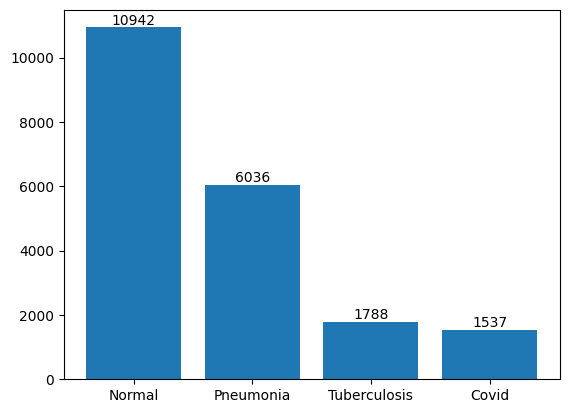

In [9]:
balance_plot_data = labeled_dataframe["label"].value_counts().rename_axis('label').reset_index(name='count')
plt.bar(balance_plot_data["label"], balance_plot_data["count"])
for i, value in enumerate(balance_plot_data["count"]):
    plt.text(i, value, value, ha="center", va="bottom")
plt.show()

We can see that there are plenty more 'Normal' X-Ray images, we would probably need to take that into consideration when training our models.
Also, we don't have a lot of 'Tuberculosis' and 'Covid' samples, which might lead our model training to be less effective for those classes.

Lets take a look at some samples from each class:

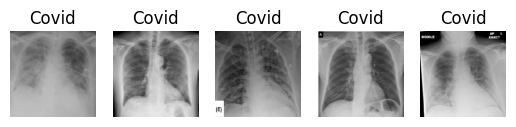

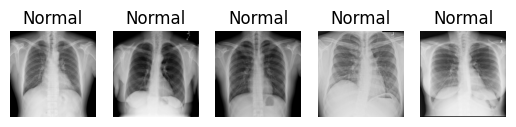

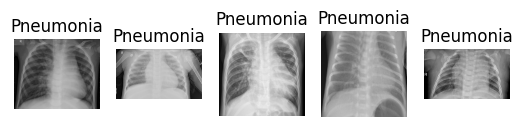

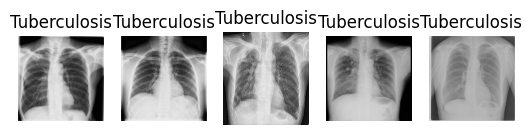

In [10]:
for label, label_data in labeled_dataframe.groupby("label"):
    for i, (image_path, label) in label_data.sample(5).reset_index(drop=True).iterrows():
        image = imread(image_path)
        image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(label)

    plt.show()

# Random Forest Model

We first want to try a simple Sklearn model to try and classify the data.

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set.

Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees. However, data characteristics can affect their performance.

## Prepare the data

To use RandomForestClassifier's fit method, we need to hold each image's raw array representation with its corresponding class. So we build a training set and a test set for this purpose.

In [11]:
def image_generator(df):
    for index, row in df.iterrows():
        image = imread(row["path"])
        image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))
        image_np = image.flatten()
        yield image_np
        
def label_generator(df):
    for index, row in df.iterrows():
        yield row["label"]

if not rfm_load_model:
    sklearn_train_set, sklearn_train_set_labels = list(image_generator(train_df)), list(label_generator(train_df))
sklearn_test_set, sklearn_test_set_labels = list(image_generator(test_df)), list(label_generator(test_df))

## Build the model

To get good results, we will use n_estimators=100 which means it will train 100 different decision trees in our forest.

In [12]:
if os.path.exists(rfm_saved_model_path) and rfm_load_model:
    with open(rfm_saved_model_path, "rb") as f:
        rfm_model = pickle.loads(f.read())
else:
    rfc = RandomForestClassifier(n_estimators=100, verbose=10, n_jobs=-1)
    rfm_model = rfc.fit(sklearn_train_set, sklearn_train_set_labels)

In [13]:
if rfm_save_model:
    with open(rfm_saved_model_path, "wb") as f:
        pickle.dump(rfm_model, f)

## Evaluate the model on test set

In [14]:
rfm_test_images_score = rfm_model.score(sklearn_test_set, sklearn_test_set_labels)
print(f"The testing score: {rfm_test_images_score*100}%")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


The testing score: 98.69490273331691%


We actually didn't expect to get such a good result on the first try, lets see individual predictions:

In [15]:
index_to_label = {v: k for k, v in train_set.class_indices.items()}

In [16]:
def rfm_predict(model, image_path, expected_label):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image_np = image.flatten()

    result = model.predict([image_np])
    print(f"Model result={result[0]}, expected result={expected_label}")

samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    rfm_predict(rfm_model, sample["path"], sample["label"])

Model result=Normal, expected result=Normal
Model result=Tuberculosis, expected result=Tuberculosis
Model result=Pneumonia, expected result=Pneumonia
Model result=Tuberculosis, expected result=Tuberculosis


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)

# CNN Model

We want to also try and see if we can achieve good classification accuracy with Convolutional Neural Network (CNN).

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery.

CNNs are also known as Shift Invariant or Space Invariant Artificial Neural Networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation-equivariant responses known as feature maps

## Build the model

First, we will try to build a simple CNN consisting of Dense layers.

Keras Dense layer is the layer that contains all the neurons that are deeply connected within themselves. This means that every neuron in the dense layer takes the input from all the other neurons of the previous layer.

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [17]:
if os.path.exists(overfitted_cnn_saved_model_path) and overfitted_cnn_load_model:
    overfitted_cnn_model = keras.models.load_model(overfitted_cnn_saved_model_path)
    trained = True
else:
    trained = False
    overfitted_cnn_model = keras.Sequential()
    overfitted_cnn_model.add(keras.layers.Flatten())
    overfitted_cnn_model.add(Dense(128, activation="relu"))
    overfitted_cnn_model.add(Dense(64, activation="relu"))
    overfitted_cnn_model.add(Dense(32, activation="relu"))
    overfitted_cnn_model.add(Dropout(0.2))
    overfitted_cnn_model.add(Dense(4, activation="sigmoid"))

    overfitted_cnn_model.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

In [18]:
def show_history(history_data):
    loss = history_data["loss"]
    accuracy = history_data["accuracy"]
    val_loss = history_data["val_loss"]
    val_accuracy = history_data["val_accuracy"]
    total_epochs = len(loss)
    for i in range(total_epochs):
        print(f"Epoch {i+1}/{total_epochs}")
        print(f"loss: {loss[i]:.4f} - accuracy: {accuracy[i]:.4f} - val_loss: {val_loss[i]:.4f} - val_accuracy: {val_accuracy[i]:.4f}")
    
if os.path.exists(overfitted_cnn_saved_model_fit_results_path) and not overfitted_cnn_train_again and trained:
    with open(overfitted_cnn_saved_model_fit_results_path, "rb") as f:
        overfitted_cnn_history = pickle.load(f)
    show_history(overfitted_cnn_history)
else:
    train_set.reset()
    validation_set.reset()
    results = overfitted_cnn_model.fit(train_set, epochs=1, validation_data=validation_set)
    overfitted_cnn_history = results.history
    with open(overfitted_cnn_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(overfitted_cnn_history, f)

Epoch 1/1
loss: 1.7181 - accuracy: 0.5461 - val_loss: 1.1413 - val_accuracy: 0.5437


In [19]:
if overfitted_cnn_save_model:
    overfitted_cnn_model.save(overfitted_cnn_saved_model_path)

## Evaluate the model on test set

In [20]:
test_set.reset()
overfitted_cnn_test_loss, overfitted_cnn_test_accuracy = overfitted_cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {overfitted_cnn_test_accuracy*100}%")
print(f"The testing loss is: {overfitted_cnn_test_loss*100}%")

254/254 [==============================] - 62s 240ms/step - loss: 1.1482 - accuracy: 0.5277
The testing accuracy is: 52.77025103569031%
The testing loss is: 114.82201814651489%


So we got pretty bad results compared to our Random Forest Classifier, ~53% accuracy is not good enough. Lets see the distribution of mistakes across classes:

In [21]:
def generate_per_class_report(model):
    report = {}
    for group, frame in test_df.groupby("label"):
        group_test_set = test_datagen.flow_from_dataframe(dataframe=frame, x_col="path", y_col="label", class_mode="categorical", seed=0x1337, batch_size=16, target_size=(224, 224))
        group_label = test_set.class_indices[group]
        group_predictions = model.predict(group_test_set)
        tp = sum(group_predictions.argmax(axis=1) == group_label)
        fp = len(frame) - tp
        report[group] = {"tp": tp, "fp": fp}
    return report

def print_report(report):
    for group, results in report.items():
        total = results["tp"] + results["fp"]
        success_rate = float(results["tp"])/total
        print(f"{group}: {success_rate*100}%")

In [22]:
overfitted_cnn_report = generate_per_class_report(overfitted_cnn_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 2s 104ms/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 34s 257ms/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 11s 147ms/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 14s 569ms/step


In [23]:
print_report(overfitted_cnn_report)

Covid: 0.0%
Normal: 99.95335820895522%
Pneumonia: 0.0%
Tuberculosis: 0.0%


So it looks like the model was able to only classify Normal images.

# Prediction of an image

In [24]:
def predict(model, image_path):
    test_image = tsimage.load_img(image_path, target_size=(224, 224))
    test_image = tsimage.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255

    result = model.predict(test_image)
    predicted_class = index_to_label[int(result.argmax(axis=-1))]
    return predicted_class
    
    
samples = test_df.sample(n = 30)
for index, sample in samples.iterrows():
    predicted_class = predict(overfitted_cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 109ms/step
Model result=Normal, expected result=Tuberculosis
1/1 [==============================] - 0s 39ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 55ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 52ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 38ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 40ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 48ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 46ms/step
Model result=Normal, expected result=Normal
1/1 [==============================] - 0s 54ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 60ms/step
Model result=Normal, expected result=Normal
1/1 [===================

And now we understand why, it seems that it always predicts 'Normal' despite the input being images from different classes.
Lets try to train it a bit more and see if it helps.

# Continue training the model for 5 epochs

In [25]:
trained = False
if os.path.exists(overfitted_cnn_saved_5epochs_model_path) and overfitted_cnn_load_5epochs_model:
    overfitted_cnn_model = keras.models.load_model(overfitted_cnn_saved_5epochs_model_path)
    trained = True

In [26]:
if os.path.exists(overfitted_cnn_saved_5epochs_model_fit_results_path) and not overfitted_cnn_train_5epochs_again and trained:
    with open(overfitted_cnn_saved_5epochs_model_fit_results_path, "rb") as f:
        overfitted_cnn_5epochs_history = pickle.load(f)
    show_history(overfitted_cnn_5epochs_history)
else:
    train_set.reset()
    validation_set.reset()
    results = overfitted_cnn_model.fit(train_set, epochs=4, validation_data=validation_set)
    overfitted_cnn_5epochs_history = results.history
    with open(overfitted_cnn_saved_5epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(overfitted_cnn_5epochs_history, f)

Epoch 1/4
loss: 1.1132 - accuracy: 0.5400 - val_loss: 1.1125 - val_accuracy: 0.5437
Epoch 2/4
loss: 1.1012 - accuracy: 0.5400 - val_loss: 1.1114 - val_accuracy: 0.5437
Epoch 3/4
loss: 1.1002 - accuracy: 0.5400 - val_loss: 1.1118 - val_accuracy: 0.5437
Epoch 4/4
loss: 1.1002 - accuracy: 0.5400 - val_loss: 1.1117 - val_accuracy: 0.5437


In [27]:
if overfitted_cnn_save_5epochs_model:
    overfitted_cnn_model.save(overfitted_cnn_saved_5epochs_model_path)

## Measure the trained model

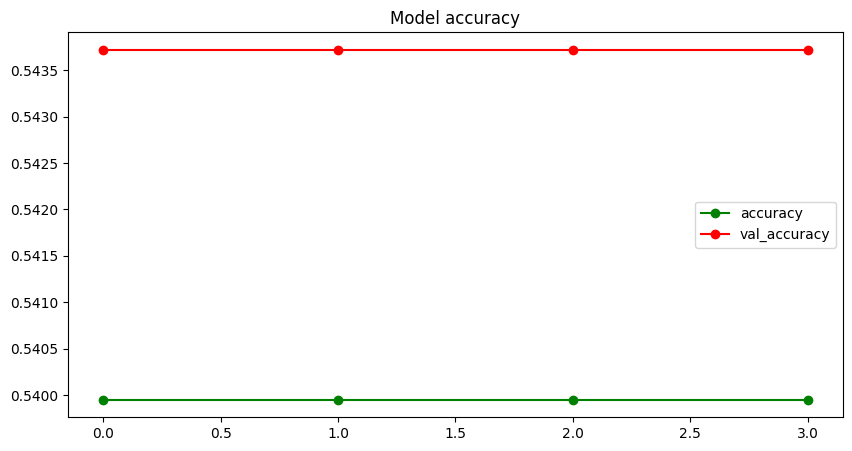

In [28]:
def show_model_plot(history, value):
    plt.figure(figsize=(10, 5))
    plt.title(f"Model {value}")
    plt.plot(history[value], "go-")
    plt.plot(history[f"val_{value}"], "ro-")
    plt.legend([value, f"val_{value}"])
    plt.show()
    
show_model_plot(overfitted_cnn_5epochs_history, "accuracy")

The accuracy stays the same across epochs, which means training the model 4 more epochs didn't really help us, and the model remained extremely overfitted to the 'Normal' class.

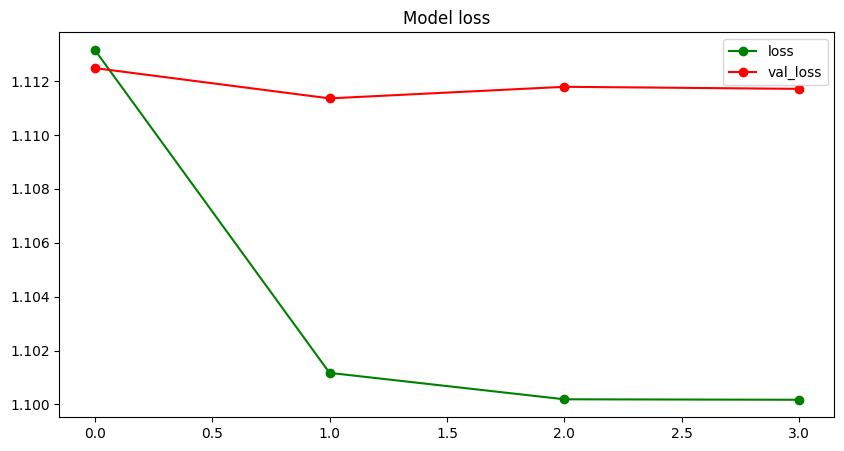

In [29]:
show_model_plot(overfitted_cnn_5epochs_history, "loss")

It seems that the loss continues to drop despite the model accuracy remaining the same, but it doesn't really help us here and we need to find a better way to handle the model overfitting behaviour.

## Evaluate the model on test set

In [30]:
test_set.reset()
overfitted_cnn_5epochs_test_loss, overfitted_cnn_5epochs_test_accuracy = overfitted_cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {overfitted_cnn_5epochs_test_accuracy*100}%")
print(f"The testing loss is: {overfitted_cnn_5epochs_test_loss*100}%")

254/254 [==============================] - 61s 239ms/step - loss: 1.1209 - accuracy: 0.5277
The testing accuracy is: 52.77025103569031%
The testing loss is: 112.08620071411133%


In [31]:
overfitted_cnn_5epochs_report = generate_per_class_report(overfitted_cnn_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 2s 103ms/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 35s 260ms/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 11s 146ms/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 13s 569ms/step


In [32]:
print_report(overfitted_cnn_5epochs_report)

Covid: 0.0%
Normal: 99.95335820895522%
Pneumonia: 0.0%
Tuberculosis: 0.0%


# Prediction of an image

In [33]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(overfitted_cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 88ms/step
Model result=Normal, expected result=Tuberculosis
1/1 [==============================] - 0s 51ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 49ms/step
Model result=Normal, expected result=Pneumonia
1/1 [==============================] - 0s 33ms/step
Model result=Normal, expected result=Normal


As we suspected we got the exact same results, the model always predicts the 'Normal' class regardless of the input image.

## Building an improved model

Instead of training the model more, lets try changing its layers.
After some research we found an article describing how to handle imbalanced dataset like ours to avoid overfitting: https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/.

We will use 3 of its recommendations to avoid overfitting:
1. Regularization
2. Weight Initialization
3. Weight Constraints

In [34]:
if os.path.exists(cnn_saved_model_path) and cnn_load_model:
    cnn_model = keras.models.load_model(cnn_saved_model_path)
    trained = True
else:
    trained = False
    cnn_model = keras.Sequential()
    cnn_model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", input_shape=(224, 224, 3)))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(l=0.01)))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(4, activation="sigmoid"))

    cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

We also found that Keras recommends passing the 'fit' method a dictionary that will dictate how effective training with each class' sample will be on the model.

In [35]:
classes = np.unique(labeled_dataframe["label"])
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=classes,
                                                  y=labeled_dataframe["label"])
weights = {i:class_weights[i] for i in range(len(classes))}
print(weights)

{0: 3.3023747560182173, 1: 0.4638777188813745, 2: 0.8409128561961564, 3: 2.8387863534675617}


We can see that it makes 'Covid' (0 label) the most effective when training, as opposed to 'Normal' (1 label).

In [36]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

We would also use EarlyStopping which we learned in class to reduce overfitting behaviour because it stops training when a monitored metric has stopped improving.

In [37]:
if os.path.exists(cnn_saved_model_fit_results_path) and not cnn_train_again and trained:
    with open(cnn_saved_model_fit_results_path, "rb") as f:
        cnn_history = pickle.load(f)
    show_history(cnn_history)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=1, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_history = results.history
    with open(cnn_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_history, f)

Epoch 1/1
loss: 1.2241 - accuracy: 0.7776 - val_loss: 0.5999 - val_accuracy: 0.8270


In [38]:
if cnn_save_model:
    cnn_model.save(cnn_saved_model_path)

## Evaluate the model on test set

In [39]:
test_set.reset()
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_test_accuracy*100}%")
print(f"The testing loss is: {cnn_test_loss*100}%")

254/254 [==============================] - 141s 555ms/step - loss: 0.5436 - accuracy: 0.8493
The testing accuracy is: 84.92981791496277%
The testing loss is: 54.3609082698822%


Our CNN model greatly improved, from ~53% accuracy (which was caused only because 53% of the images were Normal) to ~85% accuracy. Lets see how good our model predicted each class.

In [40]:
cnn_report = generate_per_class_report(cnn_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 9s 434ms/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 77s 578ms/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 37s 483ms/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 21s 900ms/step


In [41]:
print_report(cnn_report)

Covid: 97.5%
Normal: 77.1455223880597%
Pneumonia: 94.90550534100247%
Tuberculosis: 86.31578947368422%


# Prediction of an image

In [42]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 156ms/step
Model result=Tuberculosis, expected result=Tuberculosis
1/1 [==============================] - 0s 80ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 82ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 95ms/step
Model result=Normal, expected result=Normal


We are really happy with the major improvement of our new model. Lets see if we can improve it further.

# Continue training the model for 5 epochs

In [43]:
trained = False
if os.path.exists(cnn_saved_5epochs_model_path) and cnn_load_5epochs_model:
    cnn_model = keras.models.load_model(cnn_saved_5epochs_model_path)
    trained = True

In [44]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [45]:
if os.path.exists(cnn_saved_5epochs_model_fit_results_path) and not cnn_train_5epochs_again and trained:
    with open(cnn_saved_5epochs_model_fit_results_path, "rb") as f:
        cnn_5epochs_history = pickle.load(f)
    show_history(cnn_5epochs_history)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=4, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_5epochs_history = results.history
    with open(cnn_saved_5epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_5epochs_history, f)

Epoch 1/4
loss: 0.4093 - accuracy: 0.9053 - val_loss: 0.4419 - val_accuracy: 0.8818
Epoch 2/4
loss: 0.2036 - accuracy: 0.9568 - val_loss: 0.4135 - val_accuracy: 0.9052
Epoch 3/4
loss: 0.1287 - accuracy: 0.9795 - val_loss: 0.3883 - val_accuracy: 0.9163
Epoch 4/4
loss: 0.1188 - accuracy: 0.9808 - val_loss: 0.4294 - val_accuracy: 0.9083


In [46]:
if cnn_save_5epochs_model:
    cnn_model.save(cnn_saved_5epochs_model_path)

## Measure the trained model

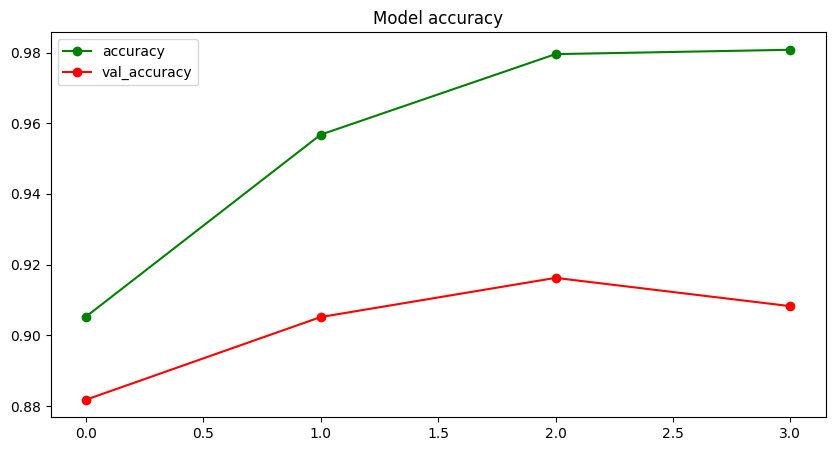

In [47]:
show_model_plot(cnn_5epochs_history, "accuracy")

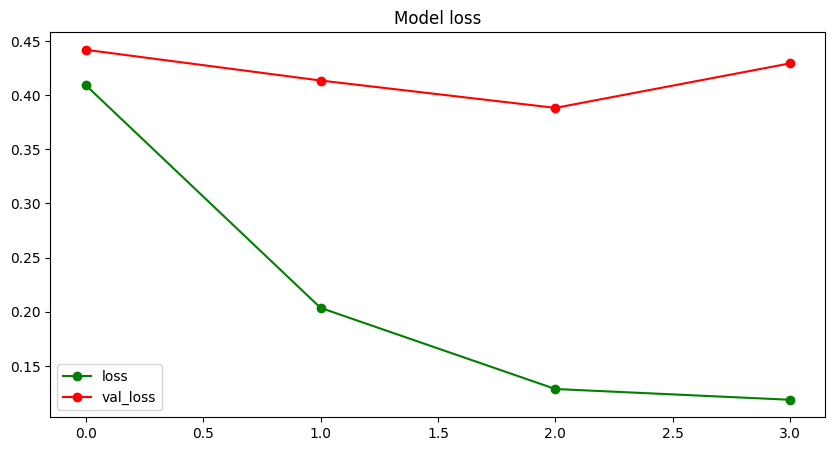

In [48]:
show_model_plot(cnn_5epochs_history, "loss")

## Evaluate the model on test set

In [49]:
test_set.reset()
cnn_5epochs_test_loss, cnn_5epochs_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_5epochs_test_accuracy*100}%")
print(f"The testing loss is: {cnn_5epochs_test_loss*100}%")

254/254 [==============================] - 146s 574ms/step - loss: 0.2397 - accuracy: 0.9549
The testing accuracy is: 95.4937219619751%
The testing loss is: 23.971514403820038%


Training the model 4 more epochs raised the accuracy on the test set by 10% (~85% -> ~95%).

In [50]:
cnn_5epochs_report = generate_per_class_report(cnn_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 9s 460ms/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 83s 616ms/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 38s 491ms/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 22s 933ms/step


In [51]:
print_report(cnn_5epochs_report)

Covid: 97.5%
Normal: 93.98320895522389%
Pneumonia: 98.60312243221036%
Tuberculosis: 92.10526315789474%


It looks like training the model 4 more epochs mainly improved the prediction success rate for the 'Normal' and 'Tuberculosis' classes.

# Prediction of an image

In [52]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 184ms/step
Model result=Normal, expected result=Tuberculosis
1/1 [==============================] - 0s 100ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 87ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 94ms/step
Model result=Normal, expected result=Normal


# Continue training the model for 10 epochs

We want to see if we can further improve the results of our model by further training it.

In [53]:
trained = False
if os.path.exists(cnn_saved_10epochs_model_path) and cnn_load_10epochs_model:
    cnn_model = keras.models.load_model(cnn_saved_10epochs_model_path)
    trained = True

In [54]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [55]:
if os.path.exists(cnn_saved_10epochs_model_fit_results_path) and not cnn_train_10epochs_again and trained:
    with open(cnn_saved_10epochs_model_fit_results_path, "rb") as f:
        cnn_10epochs_history = pickle.load(f)
    show_history(cnn_10epochs_history)
else:
    train_set.reset()
    validation_set.reset()
    results = cnn_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stop], class_weight=weights)
    cnn_10epochs_history = results.history
    with open(cnn_saved_10epochs_model_fit_results_path, 'wb') as f:
        pickle.dump(cnn_10epochs_history, f)

Epoch 1/5
loss: 0.1299 - accuracy: 0.9778 - val_loss: 0.4174 - val_accuracy: 0.9070
Epoch 2/5
loss: 0.1181 - accuracy: 0.9793 - val_loss: 0.5435 - val_accuracy: 0.9015
Epoch 3/5
loss: 0.0692 - accuracy: 0.9913 - val_loss: 0.4704 - val_accuracy: 0.9015
Epoch 4/5
loss: 0.0530 - accuracy: 0.9923 - val_loss: 0.6042 - val_accuracy: 0.8621
Epoch 5/5
loss: 0.1155 - accuracy: 0.9755 - val_loss: 0.4305 - val_accuracy: 0.9360


In [56]:
if cnn_save_10epochs_model:
    cnn_model.save(cnn_saved_10epochs_model_path)

## Measure the trained model

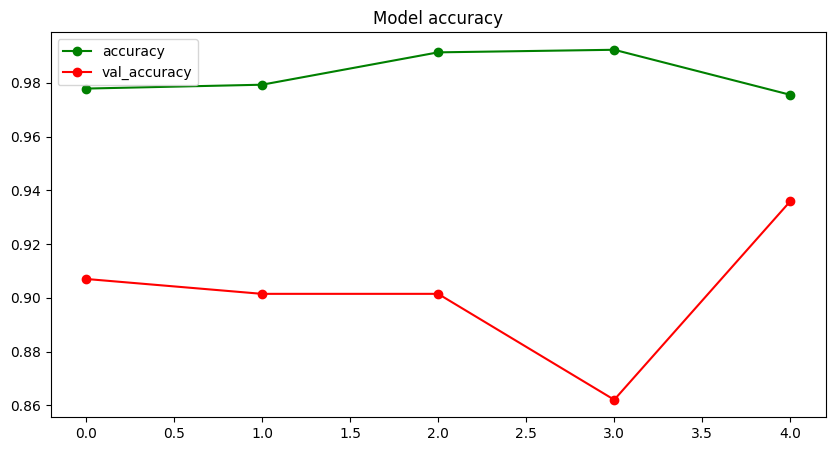

In [57]:
show_model_plot(cnn_10epochs_history, "accuracy")

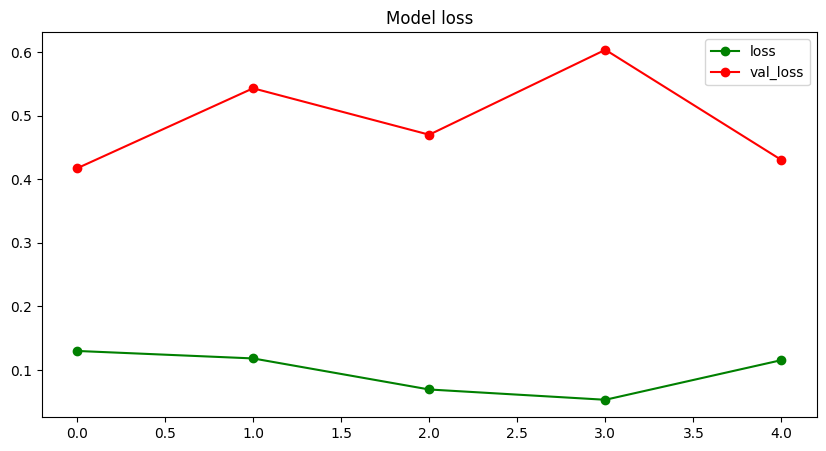

In [58]:
show_model_plot(cnn_10epochs_history, "loss")

## Evaluate the model on test set

In [59]:
test_set.reset()
cnn_10epochs_test_loss, cnn_10epochs_test_accuracy = cnn_model.evaluate(test_set)
print(f"The testing accuracy is: {cnn_10epochs_test_accuracy*100}%")
print(f"The testing loss is: {cnn_10epochs_test_loss*100}%")

254/254 [==============================] - 142s 557ms/step - loss: 0.1488 - accuracy: 0.9803
The testing accuracy is: 98.03004264831543%
The testing loss is: 14.882570505142212%


In [60]:
cnn_10epochs_report = generate_per_class_report(cnn_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 9s 433ms/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 75s 560ms/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 36s 468ms/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 21s 881ms/step


In [61]:
print_report(cnn_10epochs_report)

Covid: 96.875%
Normal: 98.50746268656717%
Pneumonia: 99.0961380443714%
Tuberculosis: 91.05263157894737%


We have reached fantastic results! our model's accuracy improved from ~95% to ~98% on the test set! The accuracy almost reached the Random Forest Classifier results.

# Prediction of an image

In [62]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(cnn_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 0s 156ms/step
Model result=Normal, expected result=Tuberculosis
1/1 [==============================] - 0s 62ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 72ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 64ms/step
Model result=Normal, expected result=Normal


## Explaining the model

Lets take one image from each class, and examine why our model chose to predict the way it did

In [106]:
explain_df = pd.DataFrame()
for label, series in labeled_dataframe.groupby("label"):
    while True:
        sample = series.sample(1)
        sample_path = next(sample.iterrows())[1]["path"]
        if label == predict(cnn_model, sample_path):
            break
    explain_df = pd.concat([explain_df, sample], ignore_index=True)

1/1 [==============================] - 0s 52ms/step


In [107]:
def get_explain_image(image_path):
    test_image = tsimage.load_img(image_path, target_size=(224, 224))
    test_image = tsimage.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255
    return test_image

explain_images = []
for idx, row in explain_df.iterrows():
    explain_images.append((get_explain_image(row["path"])[0], train_set.class_indices[row["label"]]))

We will use the package Lime to analyze the prediction of the model, it gives an easy interface to do that:

In [108]:
def silent_predict(img):
    return cnn_model.predict(img, verbose=0)

explanations = []
for img, label_idx in explain_images:
    explainer = lime_image.LimeImageExplainer()
    explanations.append((explainer.explain_instance(img.astype('double'), silent_predict), label_idx))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Now lets examine Lime's results:

Model result=Covid, expected result=Covid


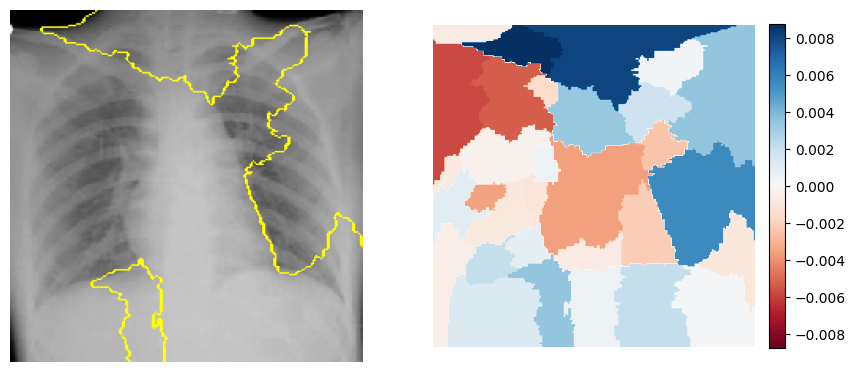

Model result=Normal, expected result=Normal


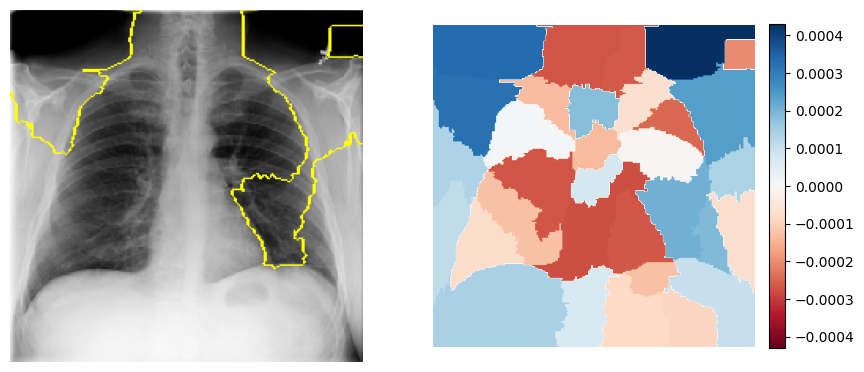

Model result=Pneumonia, expected result=Pneumonia


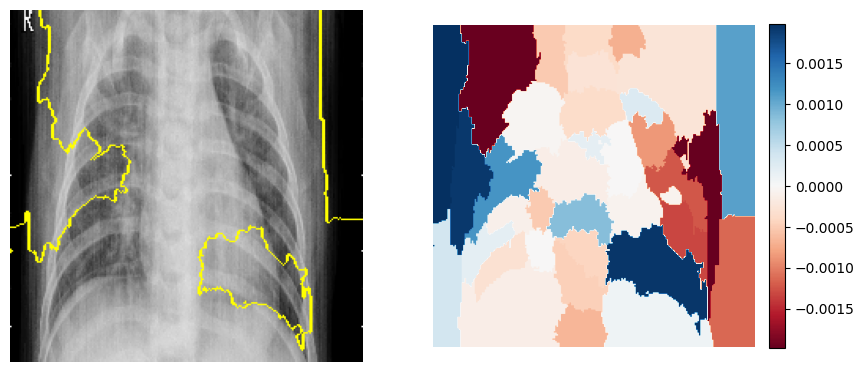

Model result=Tuberculosis, expected result=Tuberculosis


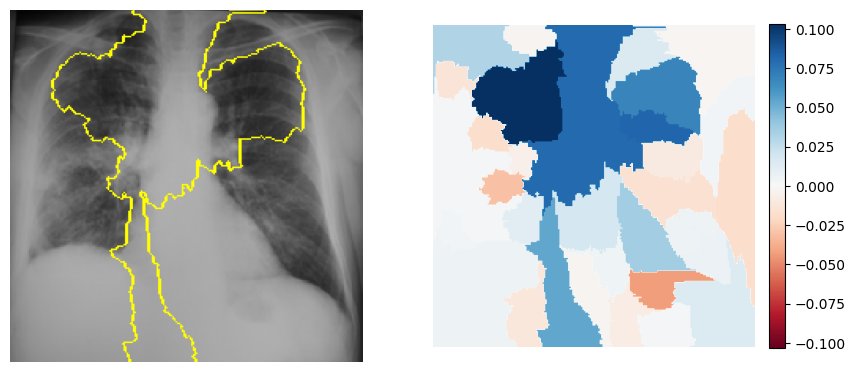

In [109]:
for explanation, label in explanations:
    predicted_label = explanation.top_labels[0]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    
    # Image with boundaries
    temp_1, mask_1 = explanation.get_image_and_mask(predicted_label, positive_only=True, num_features=5, hide_rest=False)
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax1.axis('off')
    
    # Heatmap
    dict_heatmap = dict(explanation.local_exp[predicted_label])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    im = ax2.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    print(f"Model result={index_to_label[predicted_label]}, expected result={index_to_label[label]}")
    plt.show()

Looking at the heatmap, we can see which parts of each image helped our model to reach its decision. We couldn't really find a pattern for this after running this simulation for a few times, it is really fascinating!

# Pretrained ResNet50V2 model

We want to see if we can reach better results if we use a pretrained model and only train a few new layers we add above it.

We chose to use ResNet50V2.

ResNet50 is a convolutional neural network that is 50 layers deep. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images.

ResNet50V2 is a modified version of ResNet50 that performs better than ResNet50 and ResNet101 on the ImageNet dataset. In ResNet50V2, a modification was made in the propagation formulation of the connections between blocks. ResNet50V2 also achieves a good result on the ImageNet dataset.

## Build the model

We load the pretrained model and freeze its layers so they won't be trained during our training.

In [67]:
if os.path.exists(pretrained_resnet50v2_saved_model_path) and resnet_load_model:
    resnet_model = keras.models.load_model(pretrained_resnet50v2_saved_model_path)
else:
    base_resnet_model = ResNet50V2(weights="imagenet",
                                   input_shape=(224, 224, 3),
                                   pooling="max",
                                   include_top=False,
                                   classes=4)

    for layer in base_resnet_model.layers:
        layer.trainable = False

### Create more layers on top of the model

We will use a simple structure of layers above our predefined ResNet50V2 layers, taken from the first CNN we built which suffered from overfitting.

In [68]:
if not os.path.exists(pretrained_resnet50v2_saved_model_path) or not resnet_load_model:
    resnet_model = Sequential()
    resnet_model.add(base_resnet_model)
    resnet_model.add(Flatten())

    resnet_model.add(Dense(128, activation="relu"))
    resnet_model.add(Dense(64, activation="relu"))
    resnet_model.add(Dense(32, activation="relu"))
    resnet_model.add(Dropout(0.2))
    resnet_model.add(Dense(4, activation="sigmoid"))

    resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [69]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [70]:
if os.path.exists(pretrained_resnet50v2_saved_model_fit_results_path) and not resnet_train_again:
    with open(pretrained_resnet50v2_saved_model_fit_results_path, "rb") as f:
        resnet_history = pickle.load(f)
    show_history(resnet_history)
else:
    train_set.reset()
    validation_set.reset()
    results = resnet_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stop], class_weight=weights) 
    resnet_history = results.history
    with open(pretrained_resnet50v2_saved_model_fit_results_path, 'wb') as f:
        pickle.dump(resnet_history, f)

Epoch 1/10
loss: 0.7497 - accuracy: 0.7299 - val_loss: 0.4710 - val_accuracy: 0.8190
Epoch 2/10
loss: 0.4092 - accuracy: 0.8347 - val_loss: 0.3020 - val_accuracy: 0.8969
Epoch 3/10
loss: 0.3454 - accuracy: 0.8669 - val_loss: 0.6158 - val_accuracy: 0.7743
Epoch 4/10
loss: 0.2691 - accuracy: 0.8906 - val_loss: 0.2387 - val_accuracy: 0.9218
Epoch 5/10
loss: 0.2502 - accuracy: 0.9036 - val_loss: 0.2763 - val_accuracy: 0.9039
Epoch 6/10
loss: 0.2006 - accuracy: 0.9151 - val_loss: 0.4502 - val_accuracy: 0.8562
Epoch 7/10
loss: 0.1952 - accuracy: 0.9184 - val_loss: 0.3084 - val_accuracy: 0.8987
Epoch 8/10
loss: 0.1557 - accuracy: 0.9241 - val_loss: 0.2530 - val_accuracy: 0.9221
Epoch 9/10
loss: 0.1516 - accuracy: 0.9330 - val_loss: 0.2644 - val_accuracy: 0.9175
Epoch 10/10
loss: 0.1412 - accuracy: 0.9357 - val_loss: 0.3171 - val_accuracy: 0.8966


In [71]:
if resnet_save_model:
    resnet_model.save(pretrained_resnet50v2_saved_model_path)

## Measure the trained model

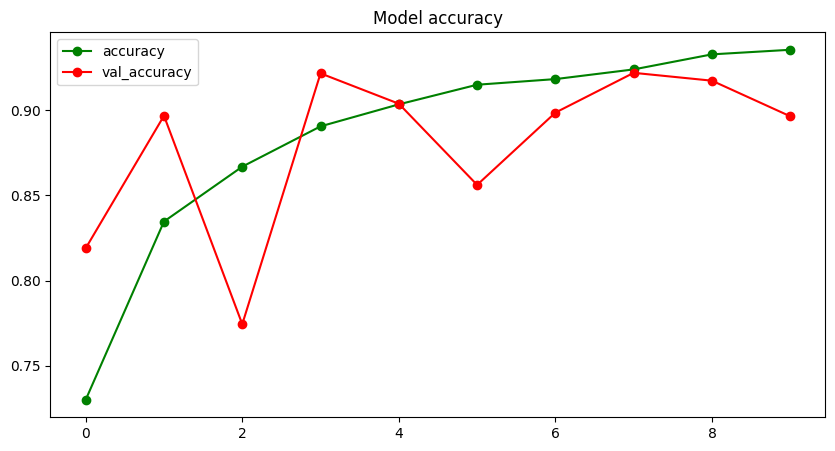

In [72]:
show_model_plot(resnet_history, "accuracy")

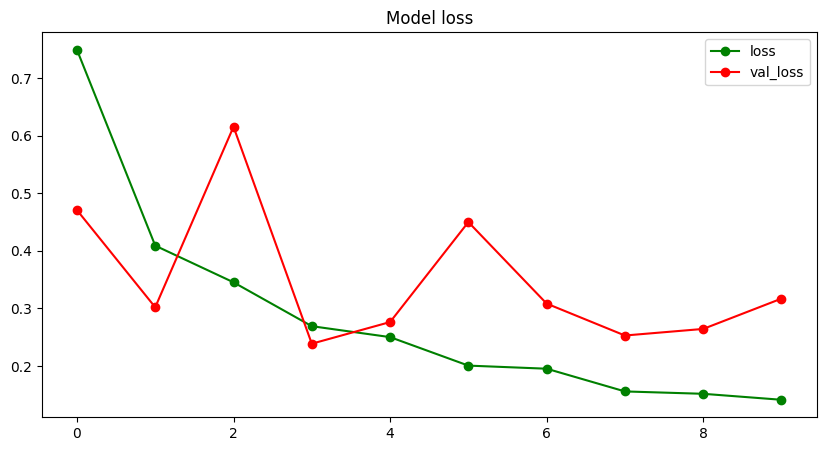

In [73]:
show_model_plot(resnet_history, "loss")

## Evaluate the model on test set

In [74]:
test_set.reset()
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_set)
print(f"The testing accuracy is: {resnet_test_accuracy*100}%")
print(f"The testing loss is: {resnet_test_loss*100}%")

254/254 [==============================] - 471s 2s/step - loss: 0.2191 - accuracy: 0.9052
The testing accuracy is: 90.51957726478577%
The testing loss is: 21.910099685192108%


After 10 training epochs, we reached pretty good results (~91% accuracy on our test set), which is good but not as good as our previous model.

In [75]:
resnet_report = generate_per_class_report(resnet_model)

Found 320 validated image filenames belonging to 1 classes.
20/20 [==============================] - 38s 2s/step
Found 2144 validated image filenames belonging to 1 classes.
134/134 [==============================] - 250s 2s/step
Found 1217 validated image filenames belonging to 1 classes.
77/77 [==============================] - 138s 2s/step
Found 380 validated image filenames belonging to 1 classes.
24/24 [==============================] - 49s 2s/step


In [76]:
print_report(resnet_report)

Covid: 98.75%
Normal: 83.06902985074626%
Pneumonia: 99.83566146261298%
Tuberculosis: 96.05263157894737%


It seems to be suffering mainly from wrongly predicting 'Normal' class images.

## Prediction of an image

In [77]:
samples = test_df.sample(n = 4)
for index, sample in samples.iterrows():
    predicted_class = predict(resnet_model, sample["path"])
    print(f"Model result={predicted_class}, expected result={sample['label']}")

1/1 [==============================] - 1s 1s/step
Model result=Tuberculosis, expected result=Tuberculosis
1/1 [==============================] - 0s 111ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 103ms/step
Model result=Pneumonia, expected result=Pneumonia
1/1 [==============================] - 0s 112ms/step
Model result=Normal, expected result=Normal


# FastAI

We wanted to try something else and learn to use another popular library (FastAI).

We need to alter our labeled DataFrame to match FastAI's API:

In [78]:
import fastai
import fastai.vision.all as fav
fai_dataframe = labeled_dataframe.copy()
fai_dataframe = fai_dataframe.applymap(lambda x: x.replace(f"{working_dir}\\", "") if isinstance(x, str) else x)
fai_dataframe

,path,label
0,Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0001_0.png,Normal
1,Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0002_0.png,Normal
2,Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0003_0.png,Normal
3,Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0004_0.png,Normal
4,Imbalanced Tuberculosis and Pneumonia dataset\Normal\CHNCXR_0005_0.png,Normal
...,...,...
20298,Imbalanced Tuberculosis and Pneumonia dataset\Tuberculosis\Tuberculosis-95.png,Tuberculosis
20299,Imbalanced Tuberculosis and Pneumonia dataset\Tuberculosis\Tuberculosis-96.png,Tuberculosis
20300,Imbalanced Tuberculosis and Pneumonia dataset\Tuberculosis\Tuberculosis-97.png,Tuberculosis
20301,Imbalanced Tuberculosis and Pneumonia dataset\Tuberculosis\Tuberculosis-98.png,Tuberculosis


It has similar features as Keras to prepare data for training.

In [79]:
tfms = fav.L([fav.Resize([224, 224, 3])])
fai_data = fav.ImageDataLoaders.from_df(fai_dataframe, working_dir, item_tfms=tfms, bs=256, seed=0x1337)

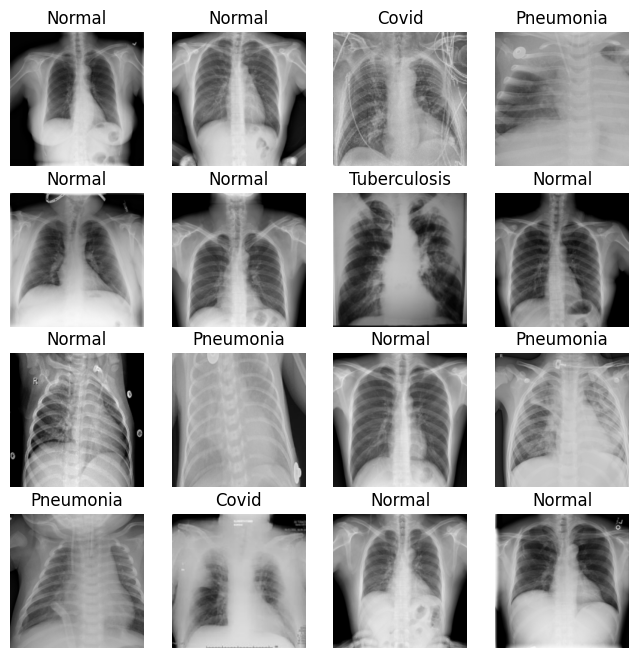

In [80]:
fai_data.show_batch(max_n = 16, figsize = (8,8))

In [81]:
from pathlib import Path
from fastai.vision.all import *
Path(fastai_models_path).mkdir(parents=True, exist_ok=True)

log_obj = CSVLogger(fname=fastai_resnet34_saved_model_log_path, append=fastai_resnet34_log_append)
fastai_resnet34 = vision_learner(fai_data, models.resnet34, metrics = [fav.error_rate , fav.accuracy], cbs=[log_obj])
fastai_resnet34.path = Path(fastai_models_path)

C:\Users\droko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\droko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We discovered there is a nice way to "guess" a good learning rate for our model, lr_find is a function that changes the learning rate during training and measures the loss value. Reading online, we found recommendations to use the valley value for training. 

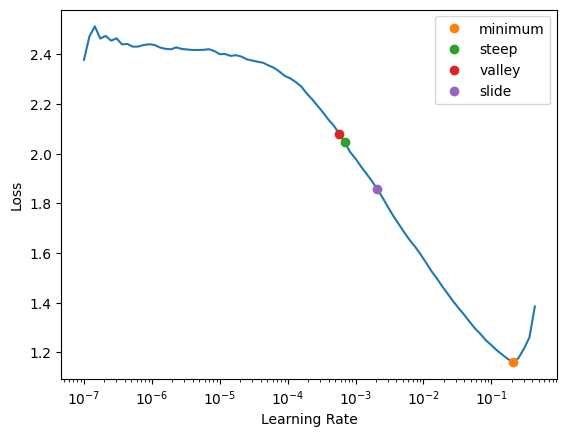

Minimum:	2.09e-02
Steepest point:	6.92e-04
Longest valley:	5.75e-04
Slide interval:	2.09e-03


In [82]:
if not fastai_resnet34_calculate_lr and os.path.exists(fastai_resnet34_saved_lr_find_plot) and os.path.exists(fastai_resnet34_saved_lrs):
    display(IPYImage(filename=fastai_resnet34_saved_lr_find_plot))
    with open(fastai_resnet34_saved_lrs, "rb") as f:
        lr_min, lr_steep, lr_valley, lr_slide = pickle.loads(f.read())
else:
    lrs = fastai_resnet34.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    lrs_data = (lrs.minimum, lrs.steep, lrs.valley, lrs.slide)
    with open(fastai_resnet34_saved_lrs, "wb") as f:
        pickle.dump(lrs_data, f)
print(f"Minimum:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

In [83]:
if fastai_resnet34_load_model:
    fastai_resnet34.load(fastai_resnet34_model_name)
    df = fastai_resnet34.csv_logger.read_log()
    display(df[:3])
else:
    fastai_resnet34.fit_one_cycle(3, lr_valley)

,epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0,0.8722629547119141,0.31034502387046814,0.09261083602905273,0.9073891639709473,1:32:43
1,1,0.40166330337524414,0.18638215959072113,0.056157633662223816,0.943842351436615,1:32:33
2,2,0.25865915417671204,0.17510958015918732,0.052955664694309235,0.947044312953949,1:32:40


After only 3 epochs, we reached 94.7% accuracy, which is pretty promising.

Lets see the top loses of our model, and its confusion matrix:

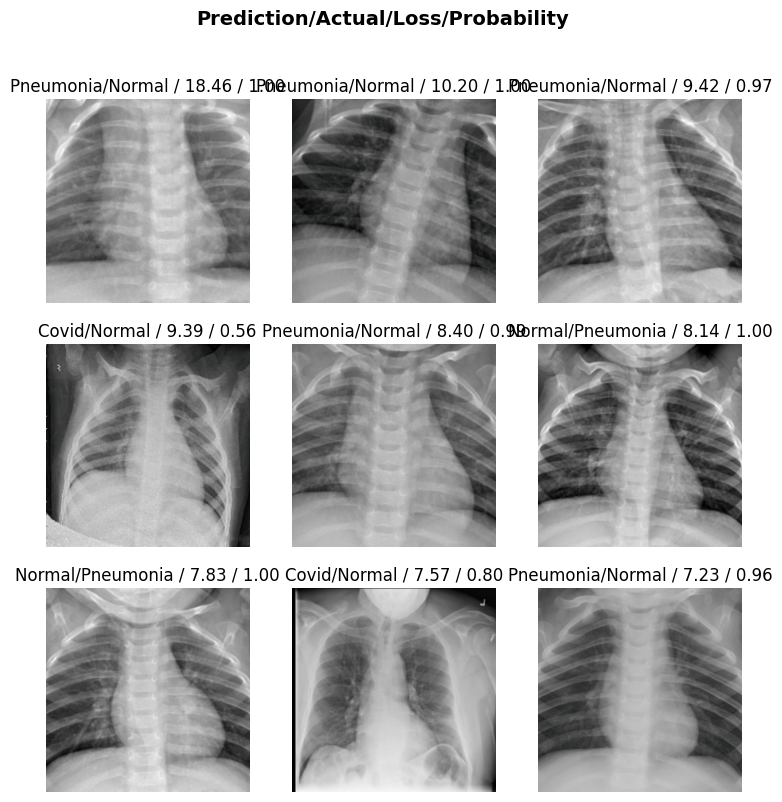

In [84]:
if not fastai_resnet34_calculate_plot_top_losses:
    display(IPYImage(filename=fastai_resnet34_saved_plot_top_losses))
else:
    interp = Interpretation.from_learner(fastai_resnet34)
    interp.plot_top_losses(9)

It looks like the model was wrong when the images were "zoomed" or "tilted".

We might be able to improve it by training it on images after tilting and zooming them randomly.

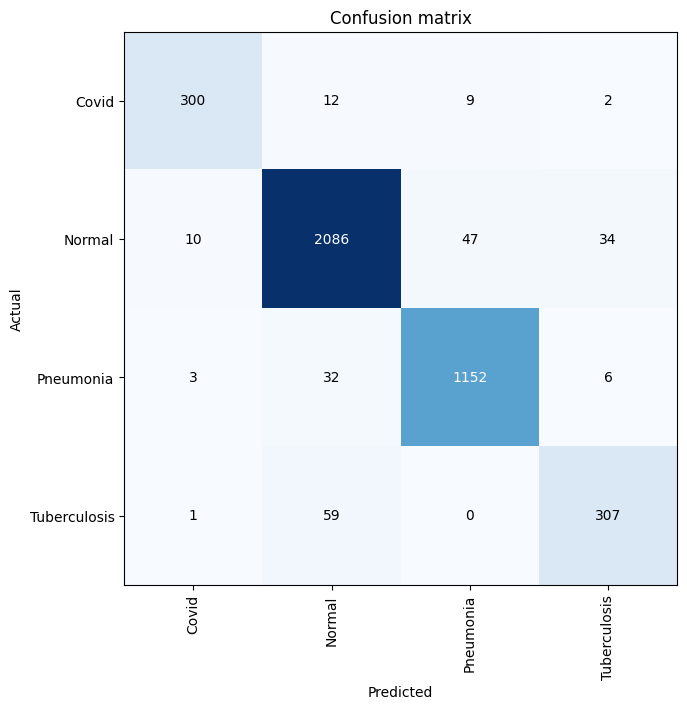

In [85]:
if not fastai_resnet34_calculate_confusion_matrix:
    display(IPYImage(filename=fastai_resnet34_saved_confusion_matrix))
else:
    class_interp = ClassificationInterpretation.from_learner(fastai_resnet34)
    losses, idxs = class_interp.top_losses()
    class_interp.plot_confusion_matrix(figsize=(7,7))

In [86]:
if fastai_resnet34_save_model:
    fastai_resnet34.save(fastai_resnet34_model_name)

### Advanced uses of neural networks with Hugging Face

#### Loading the dataset
We will use the Datasets 'juliensimon/autotrain-data-chest-xray-demo' to download our custom dataset into a DatasetDict.
The dataset is pneumonia or normal  X-ray images that are classified by 0 or 1 and labeled by NORMAL and PNEUMONIA.
Link to our specific dataset we have chosen from HuggingFace: https://huggingface.co/datasets/juliensimon/autotrain-data-chest-xray-demo

Since loading of this dataset takes close to 3 hours, we downloaded and saved it locally.

In [87]:
dataset = load_dataset("juliensimon/autotrain-data-chest-xray-demo")

Using custom data configuration juliensimon--autotrain-data-chest-xray-demo-d2b06a03704eeb38
Found cached dataset imagefolder (C:/Users/droko/.cache/huggingface/datasets/juliensimon___imagefolder/juliensimon--autotrain-data-chest-xray-demo-d2b06a03704eeb38/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [88]:
metric = load_metric("accuracy")

C:\Users\droko\AppData\Local\Temp\ipykernel_7212\2588679507.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The dataset object itself is a DatasetDict, which contains three keys per split (in this case, "train, test, validation" for a training split).

In [89]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})

To access an actual element, we select a split first, then give an index.
Each example consists of an image and a corresponding label, and we can also verify this by checking the features of the dataset

In [90]:
example = dataset["train"][10]
example
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None)}

We will use a default model of transformers -> 'image-classification' to see the results of them on our dataset

In [91]:
classifier = pipeline('image-classification')

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


Lets examine a random image from the dataset.

In [93]:
labels = ['NORMAL', #0 
          'PNEUMONIA',] #1

img = dataset["train"][2]["image"]
img_class = dataset["train"][2]["label"]
labels[img_class]

'NORMAL'

In [94]:
result = classifier(img)
result

[{'score': 0.011780556291341782, 'label': 'screw'},
 {'score': 0.011688271537423134,
  'label': 'odometer, hodometer, mileometer, milometer'},
 {'score': 0.00856933742761612, 'label': 'nematode, nematode worm, roundworm'},
 {'score': 0.007959977723658085, 'label': 'knee pad'},
 {'score': 0.007952597923576832, 'label': 'barrel, cask'}]

We can see that the results of the default image classifier are wrong and it gives us labels like "screw", "odometer, hodometer, mileometer, milometer" with low score values.

Now we will use "zero-shot-image-classification" with the default "openai/clip-vit-base-patch32" model and define our labels

In [95]:
classifier_1 = pipeline('zero-shot-image-classification', "openai/clip-vit-base-patch32")

We'll use the new classifier with the same image and labels we used before. the classifier will analyze the image and the names of the labels, and will yield the label whose name is most similar to the picture.

In [96]:
classifier_1(img, candidate_labels=labels)

[{'score': 0.9998255372047424, 'label': 'PNEUMONIA'},
 {'score': 0.00017449725419282913, 'label': 'NORMAL'}]

We can see that it was totally wrong, it predicted the image was Pneumonia with a score of 0.9998 but it was a normal healthy image.

#### Preprocessing the data
Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to resizing them to a particular size and normalizing the color channels using a mean and standard deviation.

In addition, data augmentation during training (like random cropping and flipping) is performed to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

In [97]:
model_chest_xray = "juliensimon/autotrain-chest-xray-demo-1677859324"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_chest_xray)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### Pipeline API
An alternative way to quickly perform inference with any model on the hub is by leveraging the Pipeline API, which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object.

In this notebook, we'll fine-tune from the https://huggingface.co/juliensimon/autotrain-chest-xray-demo-1677859324.   We are using an existing model from HuggingFace, which was trained on a data set similar to ours.

Let's showcase this for our trained model:

In [98]:
pipe = pipeline("image-classification", model_chest_xray)
pipe(img)

[{'score': 0.9989546537399292, 'label': 'NORMAL'},
 {'score': 0.001045374432578683, 'label': 'PNEUMONIA'}]

As we can see, it does not only show the class label with the highest probability, but return the top 2 labels, with their corresponding scores. 